In [1]:
from pymongo import MongoClient
import os
import pandas as pd
from IPython.display import display
from aco.aco_final.MuseumGraphManager import MuseumGraphManager
from aco.aco_final.AlgorithmController import AlgorithmController
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# pd.reset_option('all')

# Utility Functions

In [3]:
def pheromone_info(graph, edges=None, use_dataframe=False):
    edge_data = []
    if edges is None:
        edges = graph.edges()

    for edge in edges:
        u, v = edge
        if not use_dataframe:
            print(f'Edge {u}->{v}, pheromone: {graph[u][v]["pheromone"]}, '
                  f'weight: {graph[u][v]["weight"]}')
        d = {"nodeA": u,
             "nodeB": v,
             "pheromone": graph[u][v]["pheromone"],
             "weight": graph[u][v]["weight"]
             }
        edge_data.append(d)

    if use_dataframe:
        return pd.DataFrame.from_dict(edge_data)

# Load intermediate states if needed
def load_saved_state_pickles(state_pickles_dir):
    
    def custom_sort(element):
        no_extension = element.split('.')[0]
        return int(no_extension.split('_')[-1])
    
    def sort_list(input_list):
        return sorted(input_list, key=custom_sort)
        
    state_pickles = [f for f in listdir(state_pickles_dir) if isfile(join(state_pickles_dir, f)) and 'pickle' in str(f)]
    if len(state_pickles) == 0:
        print("ERROR: no saved state pickles found")
    
    sorted_state_pickles = sort_list(state_pickles)
    algorithm_states = []
    for sp in sorted_state_pickles:
        full_sp_path = f"{state_pickles_dir}/{sp}"
        state_instance = pickle.load(open(full_sp_path, 'rb'))
        algorithm_states.append(state_instance)
        print(f"Loaded state: {sp}")   
    
    return algorithm_states

def save_algorithm_states_to_pickles(controller, workdir):
    for n, algo_state in enumerate(controller.algorithm_states):
        intermediate_state_name = f"intermediate_state_{limit}iters_{n+1}"
        path_to_pkl = f"{workdir}/{intermediate_state_name}.pickle"
        pickle.dump(algo_state, open(path_to_pkl, 'wb'))
        print(f"Saved state: {intermediate_state_name}")

def split_dataframe(df, subset_size=20):
    # Split the DataFrame into smaller DataFrames with N elements each
    dataframes = []
    
    for i in range(0, len(df), subset_size):
        subset_df = df.iloc[i:i + subset_size]
        dataframes.append(subset_df)

    return dataframes

def int_to_roman(num):
    if not isinstance(num, int) or not 0 < num < 4000:
        raise ValueError("Input must be an integer between 1 and 3999")

    # Define the Roman numeral symbols and their corresponding values
    roman_numerals = {
        1000: 'M',
        900: 'CM',
        500: 'D',
        400: 'CD',
        100: 'C',
        90: 'XC',
        50: 'L',
        40: 'XL',
        10: 'X',
        9: 'IX',
        5: 'V',
        4: 'IV',
        1: 'I'
    }

    result = ''
    for value, numeral in roman_numerals.items():
        while num >= value:
            result += numeral
            num -= value

    return result

def plot_pheromone_stratifications(stratifications_dict, iteration_number='N/A'):
    plt.figure()
    # Remove data points whose values are 0
    clean_stratifications_dict = {}
    for k,v in stratifications_dict.items():
        if v > 0:
            clean_stratifications_dict[k] = v
            
    stratification_data = clean_stratifications_dict.values()
    stratification_labels = clean_stratifications_dict.keys()
    colors = sns.color_palette('pastel')[0:7]
    wedgestyle = {'linewidth': 1, 'linestyle': 'solid', 'edgecolor':'k'}
    plt.pie(stratification_data, labels = stratification_labels,
            colors = colors, autopct='%.0f%%', wedgeprops=wedgestyle)
    plt.title(f"Pheromone Stratification at Iteration {iteration_number}")
    plt.show()

def plot_pheromone_ecdf(pheromone_values_by_interval, pheromone_lower_bound, pheromone_upper_bound, iteration_number='N/A'):
    plt.figure()
    all_pheromone_values_list = []
    for pher_list_interval in pheromone_values_by_interval.values():
        all_pheromone_values_list.extend(pher_list_interval)
    pheromone_dataframe = pd.DataFrame(data=all_pheromone_values_list, columns=['Pheromone Level'])

    my_ecdf_plot = sns.ecdfplot(data=pheromone_dataframe,x='Pheromone Level')
    my_ecdf_plot.axvline(x = pheromone_lower_bound, ymin = 0, ymax = 1, color="green",
                         linestyle = "dashed", linewidth=0.5)
    my_ecdf_plot.axvline(x = pheromone_upper_bound, ymin = 0, ymax = 1, color="green", 
                         linestyle = "dashed", linewidth=0.5)
    my_ecdf_plot.text(pheromone_lower_bound + 0.1*pheromone_lower_bound, 0.1,'Rho_min', fontsize=9)
    my_ecdf_plot.text(pheromone_upper_bound - 0.15*pheromone_upper_bound ,0.1,'Rho_max', fontsize=9)
    my_ecdf_plot.set(title=f"Pheromone Empirical Cumulative Distribution Function at Iteration {iteration_number}")
    plt.show()

def get_pct_pheromone_in_interval(pheromone_values_by_interval, interval_id, pheromone_value_to_match):
    cnt = 0
    total_vals_interval = len(pheromone_values_by_interval[interval_id])
    if total_vals_interval == 0:
        return 0
    for v in pheromone_values_by_interval[interval_id]:
        if v == pheromone_value_to_match:
            cnt+=1
    pct = round(float(cnt*100/total_vals_interval), 2)
    return pct

def plot_pheromone_evolution_by_interval_boxplot(interval_dataframe, interval_id):
    plt.figure()
    sns.boxplot(data=interval_dataframe, y="Pheromone Level", hue="Iteration", width=0.30, palette="Set2").set(
        title=f"Evolution of Pheromones in Interval {interval_id}")
    plt.show()

In [4]:
# DB Connection
CONNECTION_URI = os.getenv("MONGO_CONNECT")
client = MongoClient(CONNECTION_URI, connect=False)
db = client.virtualmuseum
Users = db['users']

In [5]:
# [OPTIONAL] CAUTION!! 
# DELETE VISITS
# Users.update_one({}, {"$set": {"visits": []}})

In [6]:
# Load rooms json
with open('resources/space.json', 'r') as f:
    rooms_json = json.load(f)

In [7]:
# Load MMAS MODEL

params = {
    'museum_graph': rooms_json,
    'alpha': 1, # pheromone control parameter (higher value means less importance to pheromone)
    'beta': 5, # weight control parameter (higher value means less importance to weight)
    'rho': 0.02,
    'pts': True,
    'pts_factor': 1,
    'num_ants': 5,
    'start_node': 'D1-1',
    'start_room': 1
}
controller = AlgorithmController(**params)
cdf = controller.pheromone_info(use_dataframe=True)
display(cdf)

,nodeA,nodeB,pheromone,weight
0,D1-1,D1-5,0.9,430.12
1,D1-1,D1-8,0.9,430.12
2,D1-1,D1-2,0.9,1003.49
3,D1-1,D1-6,0.9,1004.04
4,D1-1,D1-13,0.9,1353.29
5,D1-1,D1-10,0.9,1491.11
6,D1-1,The Annunciation,0.9,580.20
7,D1-1,Las Meninas,0.9,618.46
8,D1-1,The Nobleman with his Hand on his Chest,0.9,1235.93
9,D1-1,Las tres Gracias,0.9,1167.43


In [8]:
# Get user with all visits
user_info = Users.find_one({}, {"visits":1, "username": 1, "_id": 0})
all_visits = user_info["visits"]
valid_visits = list(filter(lambda v: (isinstance(v,list) and len(v) > 1), all_visits))
print(f"{len(valid_visits)} visits registered.")

0 visits registered.


In [9]:
# Make a list where each element is a dataframe representing each different visit
visits_dfs = []
for visit in valid_visits:
    df = pd.DataFrame.from_dict(visit)
    visits_dfs.append(df)

# Print Info on Visits
for idx, visit_df in enumerate(visits_dfs):
    
    print("**************")
    print(f"Visit {idx+1}")
    print("**************")
    
    display(df.head())
    print("\n")
    
print("-------------------")
print(f"TOTAL VISITS: {len(visits_dfs)}")

-------------------
TOTAL VISITS: 0


# Phase 1: Model Training

## Phase 1.1: MMAS Without Human Intervention

In [10]:
# MMAS Model SOLO Training (No Interactive Feedback)
N = 50

iters = 0
limit = 10

while iters < N:
    if iters == 0:
        controller.compute_initial_iterations(limit=limit)
    else:
        controller.compute_next_iterations(limit=limit)
    
    iters += 10

Starting mmas algorithm with 10 initial iterations.
Iteration:  0
Finished computing the initial 10 iterations

Continuing mmas algorithm execution with 10 more iterations.
Done 10 iterations. Waiting for more feedback

Continuing mmas algorithm execution with 10 more iterations.
Iteration:  20
Done 10 iterations. Waiting for more feedback

Continuing mmas algorithm execution with 10 more iterations.
Done 10 iterations. Waiting for more feedback

Continuing mmas algorithm execution with 10 more iterations.
Iteration:  40
Done 10 iterations. Waiting for more feedback



#### Analysis over Iterations

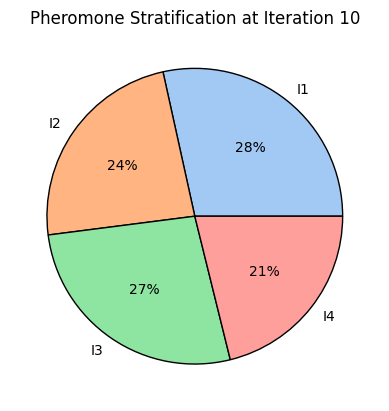

Percentage of Pheromones in Interval I1 that are equal to the Min Value: 0.0%
Percentage of Pheromones in Interval I4 that are equal to the Max Value: 0.0%


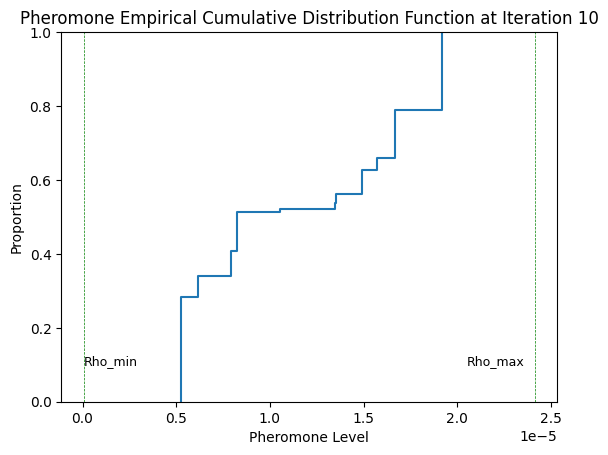

---------------------------------------------------------------------



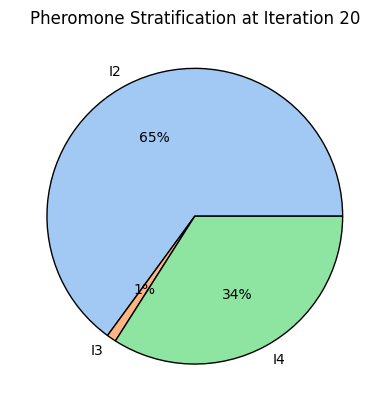

Percentage of Pheromones in Interval I1 that are equal to the Min Value: 0%
Percentage of Pheromones in Interval I4 that are equal to the Max Value: 0.0%


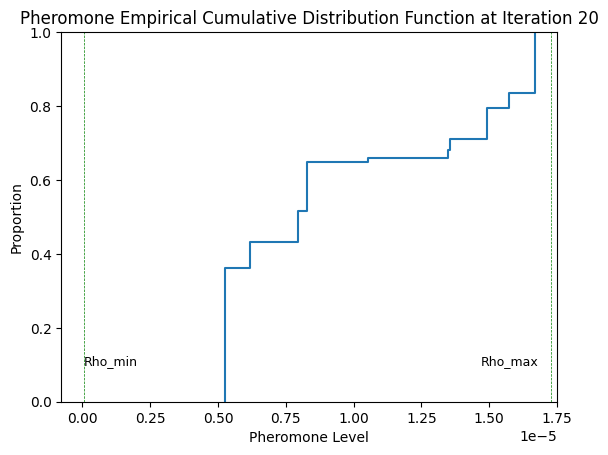

---------------------------------------------------------------------



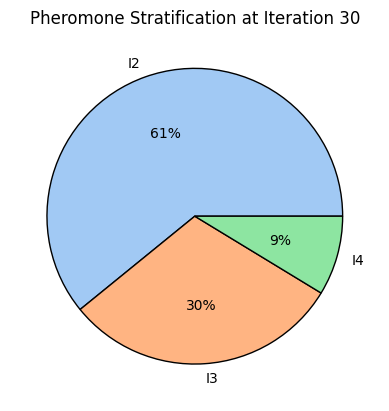

Percentage of Pheromones in Interval I1 that are equal to the Min Value: 0%
Percentage of Pheromones in Interval I4 that are equal to the Max Value: 0.0%


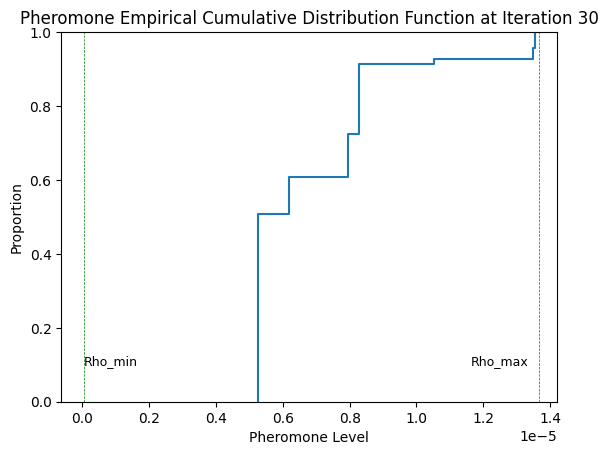

---------------------------------------------------------------------



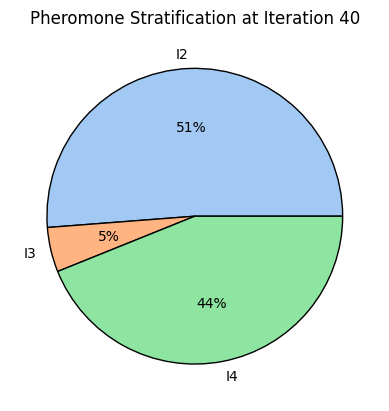

Percentage of Pheromones in Interval I1 that are equal to the Min Value: 0%
Percentage of Pheromones in Interval I4 that are equal to the Max Value: 0.0%


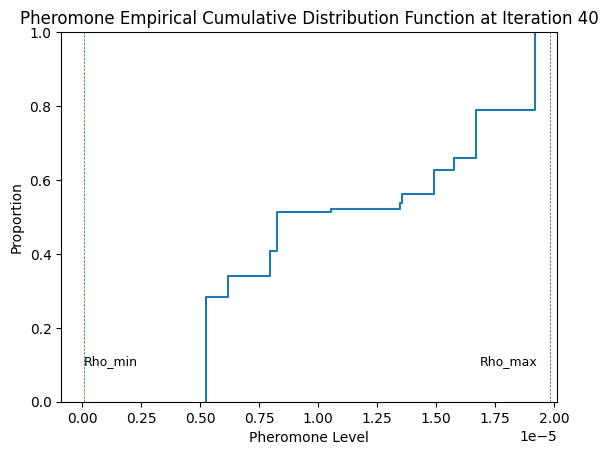

---------------------------------------------------------------------



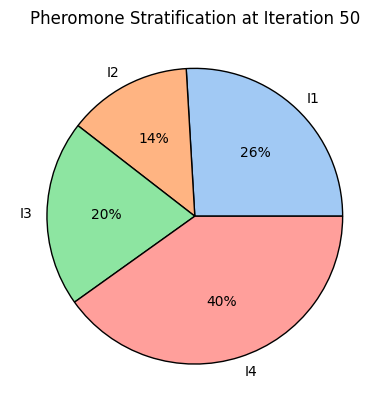

Percentage of Pheromones in Interval I1 that are equal to the Min Value: 0.0%
Percentage of Pheromones in Interval I4 that are equal to the Max Value: 60.0%


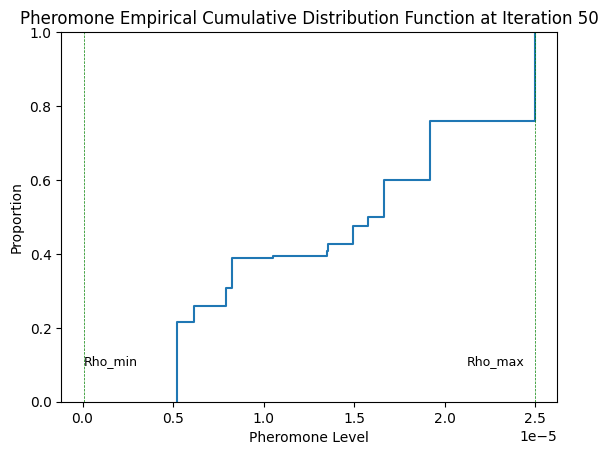

---------------------------------------------------------------------



In [11]:
# Analysis by Iteration
strat_df, info_per_state = controller.get_pheromone_stratifications(limit)
for idx, info_per_state in enumerate(info_per_state):
    iteration_number = limit*(idx+1)
    stratifications, values_in_intervals, pheromone_lower_bound, pheromone_upper_bound = info_per_state
    plot_pheromone_stratifications(stratifications, iteration_number=iteration_number)
    
    min_res = get_pct_pheromone_in_interval(values_in_intervals, "I1", pheromone_lower_bound)
    print(f"Percentage of Pheromones in Interval I1 that are equal to the Min Value: {min_res}%")
    
    max_res = get_pct_pheromone_in_interval(values_in_intervals, "I4", pheromone_upper_bound)
    print(f"Percentage of Pheromones in Interval I4 that are equal to the Max Value: {max_res}%")
    
    plot_pheromone_ecdf(values_in_intervals, pheromone_lower_bound, pheromone_upper_bound, iteration_number=iteration_number)
    print("---------------------------------------------------------------------")
    print("")

In [20]:
# incluir tabla tambien
# incluir cuantas estan en el 5% superior o 5% inferior
# incluir grafica tipo distribucion probabilidad
# segun vaya poniendo graficas las comento (evitar poner varias graficas juntas sin comentar)

In [12]:
controller.print_best_sol()

Best cost: 34762.69000000002
Best path: [('D1-1', 'D1-5'), ('D1-5', 'D1-8'), ('D1-8', 'Las Meninas'), ('Las Meninas', 'D1-5'), ('D1-5', 'The Annunciation'), ('The Annunciation', 'The Nobleman with his Hand on his Chest'), ('The Nobleman with his Hand on his Chest', 'D1-10'), ('D1-10', 'D1-13'), ('D1-13', 'Las tres Gracias'), ('Las tres Gracias', 'The Garden of Earthly Delights'), ('The Garden of Earthly Delights', 'D1-10'), ('D1-10', 'D1-13'), ('D1-13', 'Saturn'), ('Saturn', 'The Meadow of San Isidro'), ('The Meadow of San Isidro', 'D13-14'), ('D13-14', 'Landscape with Psyche and Jupiter'), ('Landscape with Psyche and Jupiter', 'D6-13'), ('D6-13', 'D6-7'), ('D6-7', 'D1-6'), ('D1-6', 'D6-13'), ('D6-13', 'D6-7'), ('D6-7', 'David with the Head of Goliath'), ('David with the Head of Goliath', 'D6-13'), ('D6-13', 'D1-6'), ('D1-6', 'D6-7'), ('D6-7', 'The Surrender of Breda'), ('The Surrender of Breda', 'D7-8'), ('D7-8', 'D7-9'), ('D7-9', 'Venus and Adonis'), ('Venus and Adonis', 'D7-9'), ('D

#### Comparative Analysis of Pheromone Intervals over Iterations

In [17]:
#intervals = ["I1", "I2", "I3", "I4"]
#for interval_id in intervals:
#    df_interval = strat_df[strat_df["Pheromone Interval"]==interval_id]
#    plot_pheromone_evolution_by_interval_boxplot(df_interval, interval_id)

<AxesSubplot:xlabel='Iteration', ylabel='Pheromone Level'>

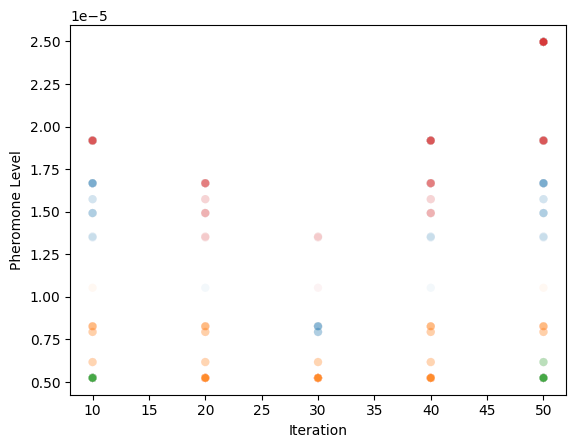

In [16]:
# buscar alguna gráfica que muestre la nebulosa de puntos
# https://tex.stackexchange.com/questions/353895/pgfplot-pretty-scatter-plot-with-opacity-in-depth-markes-in-fog
sns.scatterplot(data=strat_df, x="Iteration", y="Pheromone Level", hue="Pheromone Interval", legend=False, alpha=0.05)

In [29]:
best_sol_df = controller.print_best_sol(use_dataframe=True)
display(best_sol_df)

Best cost: 31527.470000000012


,nodeA,nodeB,pheromone,weight
0,D1-1,Las Meninas,2.208196e-07,618.46
1,Las Meninas,The Annunciation,1.441030e-05,495.78
2,The Annunciation,D1-5,1.479869e-05,175.03
3,D1-5,D3-5,2.842851e-05,330.15
4,D3-5,The Cardinal,2.842851e-05,255.86
5,The Cardinal,D1-5,8.315549e-08,378.95
6,D1-5,D1-1,2.842851e-05,430.12
7,D1-1,D1-8,2.842851e-05,430.12
8,D1-8,Judith at the Banquet of Holofernes,2.842851e-05,378.95
9,Judith at the Banquet of Holofernes,D7-8,8.315549e-08,577.81


In [30]:
no_iml_eval_dir = "evaluation/evaluation_mmas_no_human_input"

In [31]:
# Save intermediate evaluation states into pickle
# save_algorithm_states_to_pickles(controller, no_iml_eval_dir)

In [32]:
# Load states from pickles if needed
# algorithm_states = load_saved_state_pickles(no_iml_eval_dir)
algorithm_states = controller.algorithm_states
last_state = algorithm_states[-1]

## Phase 1.2: MMAS With Human-in-the-Loop

In [7]:
controller_1 = AlgorithmController(**params)
cdf_1 = controller_1.pheromone_info(use_dataframe=True)
display(cdf_1)

,nodeA,nodeB,pheromone,weight
0,D1-1,D1-5,0.9,430.12
1,D1-1,D1-8,0.9,430.12
2,D1-1,D1-2,0.9,1003.49
3,D1-1,D1-6,0.9,1004.04
4,D1-1,D1-13,0.9,1353.29
5,D1-1,D1-10,0.9,1491.11
6,D1-1,The Annunciation,0.9,580.20
7,D1-1,Las Meninas,0.9,618.46
8,D1-1,The Nobleman with his Hand on his Chest,0.9,1235.93
9,D1-1,Las tres Gracias,0.9,1167.43


In [63]:
controller.manual_pheromone_and_continue_iters(('D1-1', 'The Nobleman with his Hand on his Chest'), multiplier=1000000, limit=5)
# controller.compute_next_iterations(limit=15)
cdf = controller.pheromone_info(use_dataframe=True)
display(cdf)
controller.print_best_sol()

34721.75000000001
[('D1-1', 'The Nobleman with his Hand on his Chest'), ('The Nobleman with his Hand on his Chest', 'D1-2'), ('D1-2', 'D2-3'), ('D2-3', 'D3-5'), ('D3-5', 'The Cardinal'), ('The Cardinal', 'D1-5'), ('D1-5', 'The Annunciation'), ('The Annunciation', 'Las Meninas'), ('Las Meninas', 'D1-8'), ('D1-8', 'Judith at the Banquet of Holofernes'), ('Judith at the Banquet of Holofernes', 'D7-8'), ('D7-8', 'D7-9'), ('D7-9', 'Venus and Adonis'), ('Venus and Adonis', 'D7-9'), ('D7-9', 'D7-8'), ('D7-8', 'D1-8'), ('D1-8', 'D1-1'), ('D1-1', 'D1-5'), ('D1-5', 'D4-5'), ('D4-5', 'D3-4'), ('D3-4', 'Self-portrait'), ('Self-portrait', 'D2-3'), ('D2-3', 'D1-2'), ('D1-2', 'D2-11'), ('D2-11', 'D11-12'), ('D11-12', 'D10-12'), ('D10-12', 'A la deriva'), ('A la deriva', 'D11-12'), ('D11-12', 'D10-12'), ('D10-12', 'Hercules fighting the Nemean Lion'), ('Hercules fighting the Nemean Lion', 'D10-11'), ('D10-11', 'Christ falls on the Way to Calvary'), ('Christ falls on the Way to Calvary', 'The Crucifixi

In [58]:
controller.compute_next_iterations(limit=10)
cdf = controller.pheromone_info(use_dataframe=True)
display(cdf)

Continuing mmas algorithm execution with 10 more iterations.
Done 10 iterations. Waiting for more feedback


,nodeA,nodeB,pheromone,weight
0,D1-1,D1-5,3.926464e-05,430.12
1,D1-1,D1-8,2.053388e-05,430.12
2,D1-1,D1-2,1.148520e-07,1003.49
3,D1-1,D1-6,1.148520e-07,1004.04
4,D1-1,D1-13,1.148520e-07,1353.29
5,D1-1,D1-10,1.148520e-07,1491.11
6,D1-1,The Annunciation,1.148520e-07,580.20
7,D1-1,Las Meninas,1.148520e-07,618.46
8,D1-1,The Nobleman with his Hand on his Chest,1.148520e-07,1235.93
9,D1-1,Las tres Gracias,1.148520e-07,1167.43


In [59]:
controller.print_best_sol()

37925.21000000003
[('D1-1', 'D1-5'), ('D1-5', 'The Annunciation'), ('The Annunciation', 'D1-2'), ('D1-2', 'D2-3'), ('D2-3', 'D3-5'), ('D3-5', 'The Cardinal'), ('The Cardinal', 'D1-5'), ('D1-5', 'D4-5'), ('D4-5', 'D3-4'), ('D3-4', 'Self-portrait'), ('Self-portrait', 'D2-3'), ('D2-3', 'D1-2'), ('D1-2', 'D2-11'), ('D2-11', 'D11-12'), ('D11-12', 'A la deriva'), ('A la deriva', 'D10-12'), ('D10-12', 'Hercules fighting the Nemean Lion'), ('Hercules fighting the Nemean Lion', 'D10-11'), ('D10-11', 'Christ falls on the Way to Calvary'), ('Christ falls on the Way to Calvary', 'The Crucifixion'), ('The Crucifixion', 'D10-11'), ('D10-11', 'D2-11'), ('D2-11', 'D11-12'), ('D11-12', 'D10-11'), ('D10-11', 'D2-11'), ('D2-11', 'D2-3'), ('D2-3', 'D1-2'), ('D1-2', 'D2-11'), ('D2-11', 'D11-12'), ('D11-12', 'D10-11'), ('D10-11', 'D2-11'), ('D2-11', 'D11-12'), ('D11-12', 'D10-11'), ('D10-11', 'D2-11'), ('D2-11', 'D11-12'), ('D11-12', 'D10-12'), ('D10-12', 'Guitar and Newspaper'), ('Guitar and Newspaper', 'D